# Introduction
In this notebook I look at the [Brain Tumor MRI dataset](https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c), a collection of brain MRI images. 

The dataset does not use the [BIDS](https://github.com/bids-standard/) standard, each directory is a class and contains a collection of JPG images, organized like this:
```
base_dir:
    class_1:
        img11.jpg
        img12.jpg
    class_2:
        img21.jpg
        img21.jpg
```

The task is to classify each image in one of 15 classes (Normal, or one of 14 different kinds of tumors). The dataset contains images obtained with three different MRI techniques: T1, T1 Contrasted (T1C+), and T2. This dataset is unusual in how those are organized: in a clinical setting a neurologist would request a T1, a T1C+, and a T2 image of the same patient, but here we are given only one of the three per patient.

I will use PyTorch, and fine tune ResNet18 on these images.

Let's import the library we need and seed the random number generators for reproducibility:

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
from PIL import Image
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%config InlineBackend.figure_formats = ['svg']

import os
from torchvision.io import read_image, ImageReadMode
import torch
import torchvision.transforms.functional as F
from torch.utils.data import Dataset,random_split
from torchvision.utils import make_grid
from torchvision import datasets
import torchvision.transforms as tr
from pathlib import Path

torch.manual_seed(42)

# Create DataSet class
We could use one of the base `DataSet` classes mentioned in the [docs](http://pytorch.org/vision/main/datasets.html#base-classes-for-custom-datasets) but I prefer writing my own to be more flexible. 

In [2]:
class BrainDataset(Dataset):
    
    def __init__(self, base_dir, transforms = None):
        """
        Arguments:
            base_dir: str
                Directory where the dataset is stored
            transforms: iterable
                Collection of transforms to apply when loading an image
        """
        
        self.base_dir = Path(base_dir)
        self.transforms = transforms
        
        self.data_dicts = []
        for img in self.base_dir.glob("*oma*/*.jp*g"):
            # Get all images of sick patients, every tumor name contains "oma" 
            img_dict = {}
            img_dict["img_path"] = img
            img_dict["label"],img_dict["img_type"] = img.parent.name.split(" ")
            self.data_dicts.append(img_dict)
            
        for img in self.base_dir.glob("*NORMAL*/*.jp*g"):
            # Get all images of normal patients    
            img_dict = {}
            img_dict["img_path"] = img
            img_dict["label"],img_dict["img_type"] = "Normal", img.parent.name.split(" ")[1]
            self.data_dicts.append(img_dict)
        
        self.data = pd.DataFrame(self.data_dicts)
        self.labels = self.data["label"]
        
        self.encoder = LabelEncoder()
        self.y = self.encoder.fit_transform(self.labels)
        self.num_classes = len(self.encoder.classes_)
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        image = read_image(str(self.data.loc[idx,"img_path"]),mode=ImageReadMode.RGB) # read image into a Tensor
        # image = Image.open(self.data.loc[idx,"img_path"]).convert("RGB") # read image into a PIL Image
        label = self.y[idx]
        
        if self.transforms is not None:
            return self.transforms(image), label
        else:
            return image, label
    
    
    def display(self,idxs):
        """
        Display a few images from the dataset.
        Arguments:
            idxs: iterable
                Collection of indices of the images that will be displayed
        Returns:
            fig, axs:
                Matplotlib Figure and List(Axes) where the images are rendered
                
        
        Example: 
            BrainDataset().display([1,2])
        """
        
        img_list = [F.to_pil_image(self[idx][0]) for idx in idxs]
            
        labels = [self.labels[idx] for idx in idxs]
        
        fig,axs = plt.subplots(ncols=len(idxs),nrows=1,squeeze=False,figsize=(10,len(idxs)*16))
        
        for i,ax in enumerate(axs.flat):
            ax.imshow(img_list[i],cmap='gray')
            ax.set_title(labels[i],size=8)
            ax.grid()
            ax.axis('off')
            
        return fig,axs
    
    def _ipython_display_(self):
        # Render the underlying DataFrame when asked to display self in a notebook
        display(self.data)

In [3]:
base_dir = Path('./brain_tumor_mri/')

# Load Dataset

In [4]:
brain_data = BrainDataset("./brain_tumor_mri/",transforms=tr.Resize(size=224))

Let's check that we have picked up all images: use bash to list recursively all images below the current directory and count them

In [5]:
! ls **/*.jp* | wc -l

4465


While the number of images in the dataset we just created is 

In [6]:
len(brain_data)

4434

Ok, we have all of them. Let's take a look at this dataset

In [7]:
brain_data

img_path       label img_type
0     brain_tumor_mri/Ependimoma T2/0670f563938c4015...  Ependimoma       T2
1     brain_tumor_mri/Ependimoma T2/0906f7c8aa6f70ae...  Ependimoma       T2
2     brain_tumor_mri/Ependimoma T2/0cad4138d83f289e...  Ependimoma       T2
3     brain_tumor_mri/Ependimoma T2/0e675369d3b6a1c1...  Ependimoma       T2
4     brain_tumor_mri/Ependimoma T2/0ee15dca7a950b3e...  Ependimoma       T2
...                                                 ...         ...      ...
4429  brain_tumor_mri/_NORMAL T2/fda92e9e884f718f824...      Normal       T2
4430  brain_tumor_mri/_NORMAL T2/fdffa3aa06bcd0d7445...      Normal       T2
4431  brain_tumor_mri/_NORMAL T2/fe9adef1dd65812a090...      Normal       T2
4432                  brain_tumor_mri/_NORMAL T2/ff.jpg      Normal       T2
4433  brain_tumor_mri/_NORMAL T2/ff246a27340a9879e5a...      Normal       T2

[4434 rows x 3 columns]

The images are all in grayscale, reasonably centered with a black frame around them.

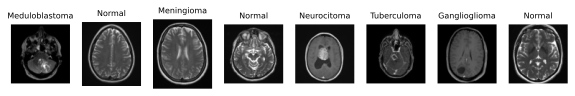

In [8]:
idxs = np.random.choice(len(brain_data),size=8)
brain_data.display(idxs);

In [9]:
brain_data.data.describe()

img_path       label img_type
count                                                4434        4434     4434
unique                                               4434          15        3
top     brain_tumor_mri/Ependimoma T2/0670f563938c4015...  Meningioma     T1C+
freq                                                    1         874     1655

Unfortunately some classes are much rarer than others, identifying Gangliomas, Germinomas, and Granulomas will be challenging.

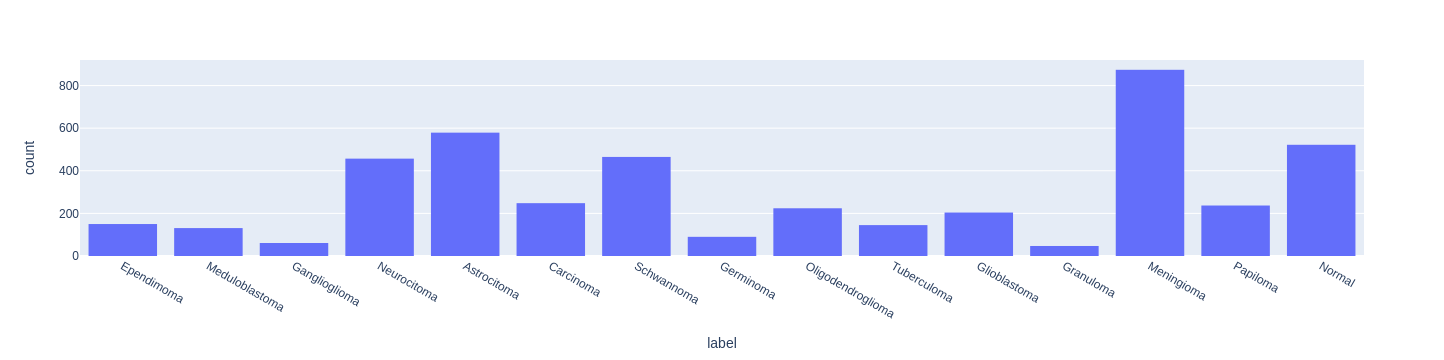

In [10]:
px.histogram(brain_data.data,x="label")

# Autocropping
Some images have a large black frame around them, which carries no information; training a model without removing them will probably not damage significantly the accuracy, but it is a waste of computational power. In a few cases there is a thin white frame as the edge of the image, and that might distract the neural network from the relevant features at the center of the image.

Here is an example of an image with a black frame that should be removed

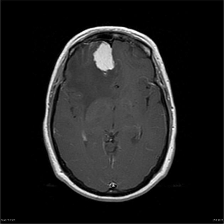

In [11]:
img = F.to_pil_image(brain_data[2000][0])
img

I tried using the `getbbox()` method from PIL, but it only removes the frame if the pixels are *exactly* black, and so it does not work in our case:

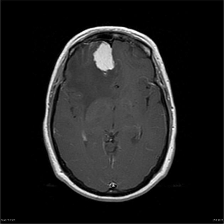

In [12]:
img.crop(img.getbbox())

An approach that works in this specific case is the following: since all images are roughly centered, and the skull is very bright, take a horizontal line through the center of the image and look at the intensity of color (0 = black, 1 = white). 

When the intensity goes above some threshold (say, 50% of the max intensity) we found the edge of the skull, and we crop the image. In pictures:

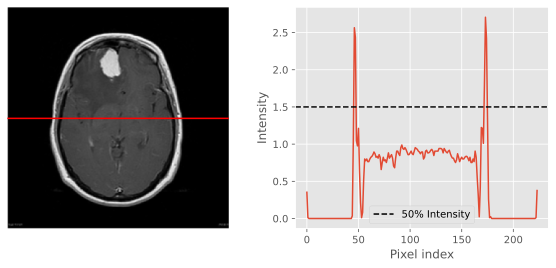

In [13]:
imgT = tr.ToTensor()(img)[:,:,]
C,H,W = imgT.shape

fig,ax = plt.subplots(1,2,figsize=(10,4))

ax[0].imshow(img)
ax[0].axhline(H//2,color="red")
ax[0].grid()
ax[0].axis("off");
       
ax[1].plot(torch.sum(imgT[:,H//2,:],axis=0))
ax[1].set_xlabel("Pixel index")
ax[1].set_ylabel("Intensity")
ax[1].axhline(0.5*torch.max(torch.sum(imgT,axis=0)),color="Black",label="50% Intensity",linestyle="--")
ax[1].legend();
# plt.plot(torch.sum(imgT[:,:,W//2],axis=0))

This is the simplest form of an edge detector. I implemented this as a PyTorch module, so it's easy to use.

In [14]:
# to define a custom transform inherit from nn.Module and give it a forward method
class CropToContent(torch.nn.Module):

    def __init__(self,threshold=0.1,ignore_frame_pixels=5):
        super().__init__()
        self.threshold = threshold
        self.ignore_frame_pixels = ignore_frame_pixels if ignore_frame_pixels > 0 else None

    def forward(self, img):
        """
        Args:
            img (PIL Image or Tensor): Image to be cropped.
        Returns:
            Tensor: Cropped image.
        """
            
        C,H,W = img.shape
        skipH = self.ignore_frame_pixels
        skipT = -self.ignore_frame_pixels if self.ignore_frame_pixels is not None else None
        
        ymax = torch.max(torch.sum(img[:,H//2,skipH:skipT],axis=0))
        xmax = torch.max(torch.sum(img[:,skipH:skipT,W//2],axis=0))
           
        bottom, top = torch.nonzero(torch.sum(img[:,H//2,skipH:skipT],axis=0) > self.threshold*ymax)[[0,-1]]
        left, right = torch.nonzero(torch.sum(img[:,skipH:skipT,W//2],axis=0) > self.threshold*xmax)[[0,-1]]
        
        return F.center_crop(img,output_size=[(right-left).item(),(top-bottom).item()])
    
    def __repr__(self):
        return f"CropToContent(threshold={self.threshold})"

Let's see what it does to the image above:

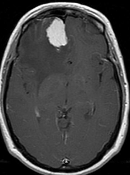

In [15]:
F.to_pil_image(CropToContent(threshold=0.1,ignore_frame_pixels=1)(F.to_tensor(img)))

Perfect. Let's reload the dataset including this transformation, and resizing the images to $224\times224$ so they're in the right shape to be fed into ResNet18.

In [16]:
brain_data = BrainDataset("./brain_tumor_mri/",transforms=tr.Compose([
    CropToContent(threshold=0.1,ignore_frame_pixels=5),
    tr.Resize([224,224]),
    ]
    ))

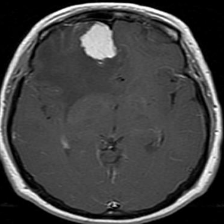

In [17]:
F.to_pil_image(brain_data[2000][0])

This transformation distorts the image, but the tumor is still clearly recognizable so I do not expect to degrade performance too much.

# Transfer learning CNN  
The model I'm using is ResNet18, followed by a fully connected layer to make the output have the correct shape (15 classes).

In [18]:
import torchvision
from torchvision.models import resnet18, ResNet18_Weights

# Using pretrained weights:
resnet = resnet18(weights="IMAGENET1K_V1")

# Using resnet as a feature extractor, don't backprop through it
# for param in resnet.parameters():
    # param.requires_grad = False

In [19]:
import pytorch_lightning as pl
from tqdm.notebook import tqdm
from torchmetrics.functional import accuracy

To simplify the training process I'm using PyTorch Lightning, so I need to define a `pl.LightningModule` that specifies what are the training step, validation step, and the optimizer.

In [20]:
class TumorClassifier(pl.LightningModule):
    def __init__(self,transforms):
        super().__init__()
        
        self.model = torch.nn.Sequential(
                    transforms,
                    resnet,
                    torch.nn.Linear(
                        resnet.fc.out_features,
                        brain_data.num_classes)
                    )
        

    def forward(self, data):
        # not needed for training, but convenient for inference
        return self.model(data) 
    
    def training_step(self,batch,batch_idx):
        logits = self(batch[0])
        preds = torch.argmax(model(batch[0]),axis=1)
        
        loss = torch.nn.functional.cross_entropy(logits,batch[1])
        acc = accuracy(preds,batch[1],task="multiclass",num_classes=brain_data.num_classes) 
        
        self.log('train_loss', loss)
        self.log('train_acc', acc)

        return loss
    
    def validation_step(self,batch,batch_idx):
        logits = self(batch[0])
        preds = torch.argmax(model(batch[0]),axis=1)
        
        loss = torch.nn.functional.cross_entropy(logits,batch[1])
        acc = accuracy(preds,batch[1],task="multiclass",num_classes=brain_data.num_classes) 
        
        self.log('valid_loss', loss)
        self.log('valid_acc', acc)
        
        return loss
    
    def test_step(self,batch,batch_idx):
        logits = self(batch[0])
        preds = torch.argmax(model(batch[0]),axis=1)
        
        loss = torch.nn.functional.cross_entropy(logits,batch[1])
        acc = accuracy(preds,batch[1],task="multiclass",num_classes=brain_data.num_classes) 
        
        self.log('valid_loss', loss)
        self.log('valid_acc', acc)
        
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adadelta(self.parameters())

## Splitting the data
We can either use `train_test_split` from `sklearn.model_selection`, which allows for stratification, or the `torch.utils.data` native `random.split`.

The advantage of the `torch` function is that it uses the `Dataset` interface, so we don't have to convert to/from pandas `DataFrame`s or `numpy` arrays. I'll test later how important stratification is. 

In [21]:
train_set, valid_set = random_split(brain_data,[0.8,0.2])

It looks like the `Subset` class does not inherit from the custom class we wrote, so it does not have the `display` method.

In [22]:
from torch.utils.data import DataLoader

In [23]:
train_loader = DataLoader(train_set,batch_size=32,shuffle=True,num_workers=12)
valid_loader = DataLoader(valid_set,batch_size=32,shuffle=False,num_workers=12)

# Augmentations
Since the dataset is small, it's best to do some data augmentation. I will use small random rotations (up to 15 degrees) and random left-right reflection. I talked to a neurologist, and they told me that some tumors grow down the median line of the brain, while others grow on the side. The latter appear with equal probability on the left and right, so using the left-right reflection is fine.

PyTorch comes with a collection of transforms that preprocess the data to the format accepted by ResNet:

In [24]:
resnet_transforms = ResNet18_Weights.IMAGENET1K_V1.transforms()
resnet_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Let's add the augmentation transforms I just discussed

In [25]:
# Including augmentations
transforms = torch.nn.Sequential(
    tr.RandomHorizontalFlip(),
    # tr.RandomAutocontrast(1),
    # tr.RandomResizedCrop()
    tr.RandomRotation(15),
     resnet_transforms,
)

model = TumorClassifier(transforms=transforms)

During training I monitored the performance using Weights&Biases.

In [26]:
# from pytorch_lightning.loggers import WandbLogger
# wandb_logger = WandbLogger()

I trained the model on a single GPU and saved its parameters. Let's load it and measure its accuracy on the validation set

In [27]:
model.load_state_dict(torch.load("resnet_fully_trained.pth"))

<All keys matched successfully>

In [28]:
epochs = 64

# from pytorch_lightning.profilers import PyTorchProfiler

trainer = pl.Trainer(accelerator="gpu",
                     max_epochs=epochs,
                     # logger=wandb_logger,
                )

torch.set_float32_matmul_precision('medium')

# trainer.fit(model, 
#             train_dataloaders=train_loader,
#             val_dataloaders=valid_loader,
#            )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ksrnk/opt/miniconda3/envs/machine-learning/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning:

Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default



In [29]:
# torch.save(model.state_dict(),"resnet_fully_trained.pth")

In [30]:
log_dicts = trainer.test(model,dataloaders=valid_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        valid_acc            0.98758465051651
       valid_loss           0.06765643507242203
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


About 99% acuracy on the validation set is not bad.

# Which examples are hard to classify?

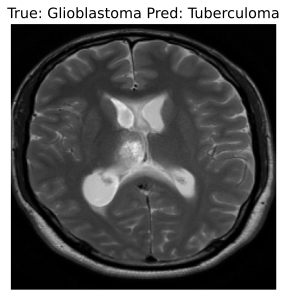

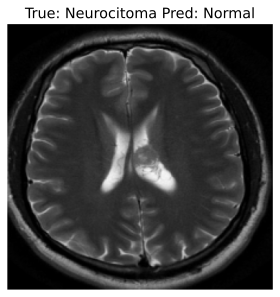

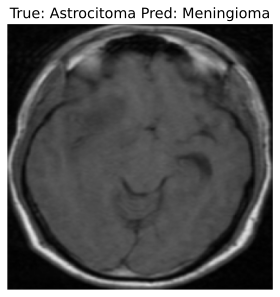

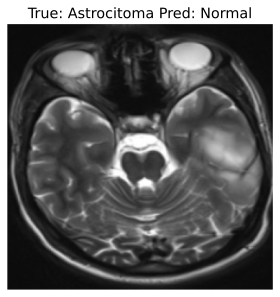

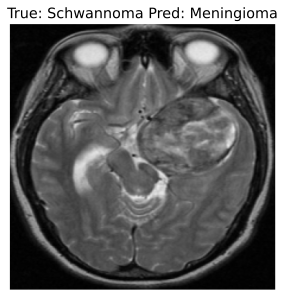

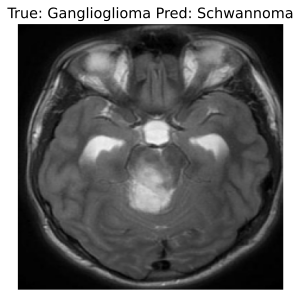

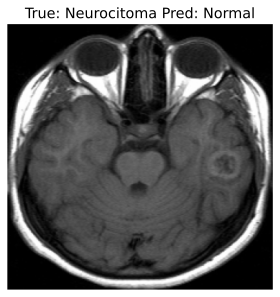

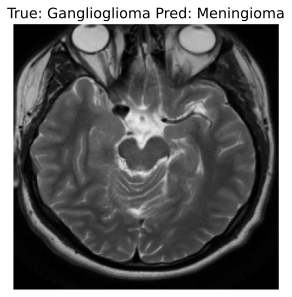

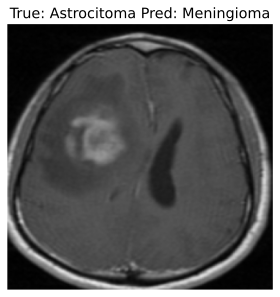

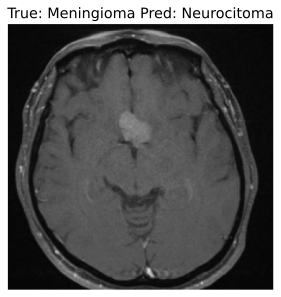

In [31]:
model.eval()

with torch.inference_mode():
    for data,label in valid_loader:
        pred_labels = torch.argmax(model(data),axis=1)
        
        idxs = torch.nonzero(pred_labels != label).T[0]
        
        for i in idxs:
            plt.figure()
            img = data[i]
            plt.imshow(F.to_pil_image(img))
            true = brain_data.encoder.classes_[label[i]]
            pred = brain_data.encoder.classes_[pred_labels[i]]
            plt.axis("off")
            plt.grid()
            plt.title(f"True: {true} Pred: {pred}")

It looks like the model misidentified a few cases as Meningiomas, which is unsurprising given that it's the most common class. There were two cases in which a tumor was misclassified as Normal, which in this application is highly undesirable. To improve on that we could define a custom loss function that highly penalizes this kind of misclassification.

# Ideas for future steps
The most important limitation of this dataset is that the three kinds of MRIs are not given for the same patient. If that was the case, I would love to try a trick: treat each image as a channel (RGB) , and feed the composite image to ResNet. In the current version of the model I'm converting a grayscale image to RGB, which is wasteful.

Furthermore, talking to that same neurologist, they told me that some kinds of tumors are easily identified because they behave differently when adding contrast (T1 vs. T1C+), I wonder if a CNN would learn this property.